In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re

# initialize a dict to store the data
llm_performance = {
    "GPT": {"accuracy": 0.8334, "recall": 0.8328, "precision": 0.3862, "f1": 0.5277},
    "LLAMA": {"accuracy": 0.7781, "recall": 0.8219, "precision": 0.3126, "f1": 0.4529},
}

def get_precision(model_string):
    return float(model_string.split(';')[0][-6:])
def get_recall(model_string):
    return float(model_string.split(';')[1])
def get_f1(model_string):
    return float(model_string.split(';')[2])

In [2]:
llm_name = "LLAMA" # or "GPT"
dataset_name = "HATESPEECH"
log_dir = f"./paper_logs/{llm_name}/{dataset_name.lower()}-{llm_name.lower() if llm_name == 'LLAMA' else llm_name}-small/"
# log_dir = f"./logs/rebuttal/{dataset_name.lower()}/"

# get all .log files in the directory
files = [f for f in os.listdir(log_dir) if f.endswith('.log')]
files.sort()
# divide the files into different cascade sizes
cascades = {}
for f in files:
    cascade_size = f.split('_')
    if '_'.join(cascade_size[0:-1]) not in cascades:
        cascades['_'.join(cascade_size[0:-1])] = []
    cascades['_'.join(cascade_size[0:-1])].append(f)
cascades

{'LR_BERT-base': ['LR_BERT-base_0.000001.log',
  'LR_BERT-base_0.000002.log',
  'LR_BERT-base_0.000003.log',
  'LR_BERT-base_0.000004.log',
  'LR_BERT-base_0.000005.log',
  'LR_BERT-base_0.000006.log',
  'LR_BERT-base_0.000007.log',
  'LR_BERT-base_0.000008.log',
  'LR_BERT-base_0.000009.log',
  'LR_BERT-base_0.000010.log',
  'LR_BERT-base_0.000020.log',
  'LR_BERT-base_0.000030.log',
  'LR_BERT-base_0.000040.log',
  'LR_BERT-base_0.000050.log',
  'LR_BERT-base_0.000060.log',
  'LR_BERT-base_0.000070.log',
  'LR_BERT-base_0.000080.log',
  'LR_BERT-base_0.000090.log',
  'LR_BERT-base_0.000100.log',
  'LR_BERT-base_0.000200.log',
  'LR_BERT-base_0.000300.log',
  'LR_BERT-base_0.000400.log',
  'LR_BERT-base_0.000500.log',
  'LR_BERT-base_0.000600.log',
  'LR_BERT-base_0.000700.log',
  'LR_BERT-base_0.000800.log',
  'LR_BERT-base_0.000900.log',
  'LR_BERT-base_0.001000.log',
  'LR_BERT-base_0.002000.log',
  'LR_BERT-base_0.003000.log',
  'LR_BERT-base_0.004000.log',
  'LR_BERT-base_0.00500

In [21]:
def plot(cascade_logs, cascade_costs):
    # plot the data
    for f in cascade_logs:
        num_lines = sum(1 for line in open(log_dir + f))
        # read last line of the file
        with open(log_dir + f, 'r') as file:
            last_line = file.readlines()[-2]
        # data format: '''m1_prediction, m2_prediction, ..., llm_prediction, ground_truth, m1_proportion, m2_proportion, ..., m1_defer_prob, m2_defer_prob, ..., m1_score, m2_score, ..., m1_accuracy, m2_accuracy, llm_accuracy, overall_accuracy'''
        data = re.split(',', last_line.strip())
        model_prop = []
    
    cascade_size = len(cascade_logs[0].split('_')) - 1
    print("cascade size: ", cascade_size)

    def plot_precision(axs):
        costs = []
        precision = []
        linear_precision = []
        # plot the data
        for f in cascade_logs:
            if ("0.00900000.log" in f) or ("0.01000000.log" in f) or ("0.00700000.log" in f):
                continue
            # read last line of the file
            with open(log_dir + f, 'r') as file:
                last_line = file.readlines()[-2]
            # data format: '''m1_prediction, m2_prediction, ..., llm_prediction, ground_truth, m1_proportion, m2_proportion, ..., m1_defer_prob, m2_defer_prob, ..., m1_score, m2_score, ..., m1_accuracy, m2_accuracy, llm_accuracy, overall_accuracy'''
            data = re.split(',', last_line.strip())
            model_prop = []
            my_precision = 0
            for k in range(cascade_size):
                model_prop.append(float(data[k + cascade_size + 2]))
                my_precision += get_precision(data[k + cascade_size * 6 + 3]) * float(data[k + cascade_size + 2])
                print('precision: ', get_precision(data[k + cascade_size * 6 + 3]), 'model proportion: ', float(data[k + cascade_size + 2]))

            llm_cost = 1 - sum(model_prop)

            llm_precision = get_precision(data[-2])
            my_precision += llm_precision * llm_cost
            overall_precision = get_precision(data[-1])
            # print overall cost and precision
            print(f, 'llm cost: ', llm_cost, 'overall precision: ', overall_precision, 'linear precision: ', my_precision)

            costs.append(llm_cost * num_lines)
            precision.append(overall_precision)
            linear_precision.append(my_precision)

        # sort the data then plot
        costs = np.array(costs)
        precision = np.array(precision)
        idx = np.argsort(costs)
        costs = costs[idx]
        precision = precision[idx]
        axs.plot(costs, precision, label = 'Online Cascade Learning')
        linear_precision = np.array(linear_precision)
        linear_precision = linear_precision[idx]
        axs.tick_params(axis='x', which='both', bottom=True, top=False, direction='out', length=5, width=1)
        axs.plot(costs, linear_precision, label = 'Online Ensemble Learning')
        axs.set_ylabel('Precision', weight='bold', fontsize=16)
        axs.axhline(y=llm_performance[llm_name]['precision'], color='r' if llm_name == "GPT" else 'g', linestyle='--', label = 'GPT 3.5 Turbo' if llm_name == "GPT" else 'LLAMA 2 70B')
        axs.set_ylim([0.2, 0.36] if llm_name == "LLAMA" else [0.26, 0.48])

        plt.xlabel('Cost Budget (number of LLM calls)', weight='bold', fontsize=16)
    
    def plot_recall(axs):
        costs = []
        recall = []
        linear_recall = []
        # plot the data
        for f in cascade_logs:
            if ("0.00900000.log" in f) or ("0.01000000.log" in f) or ("0.00700000.log" in f):
                continue
            # read last line of the file
            with open(log_dir + f, 'r') as file:
                last_line = file.readlines()[-2]
            # data format: '''m1_prediction, m2_prediction, ..., llm_prediction, ground_truth, m1_proportion, m2_proportion, ..., m1_defer_prob, m2_defer_prob, ..., m1_score, m2_score, ..., m1_accuracy, m2_accuracy, llm_accuracy, overall_accuracy'''
            data = re.split(',', last_line.strip())
            model_prop = []
            my_recall = 0
            for k in range(cascade_size):
                model_prop.append(float(data[k + cascade_size + 2]))
                my_recall += get_recall(data[k + cascade_size * 6 + 3]) * float(data[k + cascade_size + 2])
                print('recall: ', get_recall(data[k + cascade_size * 6 + 3]), 'model proportion: ', float(data[k + cascade_size + 2]))

            llm_cost = 1 - sum(model_prop)

            llm_recall = get_recall(data[-2])
            my_recall += llm_recall * llm_cost
            overall_recall = get_recall(data[-1])
            # print overall cost and recall
            print(f, 'llm cost: ', llm_cost, 'overall recall: ', overall_recall, 'linear recall: ', my_recall)

            costs.append(llm_cost * num_lines)
            recall.append(overall_recall)
            linear_recall.append(my_recall)

        # sort the data then plot
        costs = np.array(costs)
        recall = np.array(recall)
        idx = np.argsort(costs)
        costs = costs[idx]
        recall = recall[idx]
        axs.plot(costs, recall, label = 'Online Cascade Learning')
        linear_recall = np.array(linear_recall)
        linear_recall = linear_recall[idx]
        
        axs.tick_params(axis='x', which='both', bottom=True, top=False, direction='out', length=5, width=1)
        axs.plot(costs, linear_recall, label = 'Online Ensemble Learning')
        axs.set_ylabel('Recall', weight='bold', fontsize=16)
        axs.axhline(y=llm_performance[llm_name]['recall'], color='r' if llm_name == "GPT" else 'g', linestyle='--', label = 'GPT 3.5 Turbo' if llm_name == "GPT" else 'LLAMA 2 70B')
        axs.set_ylim([0.51, 0.849] if llm_name == "LLAMA" else [0.4, 0.88])
        axs.legend(loc = 'lower right')
    
    def plot_accuracy(axs):
        costs = []
        accus = []
        linear_accus = []
        # plot the data
        for f in cascade_logs:
            if ("0.0900000.log" in f) or ("0.01000000.log" in f) or ("0.00700000.log" in f):
                continue
            num_lines = sum(1 for line in open(log_dir + f))
            # read last line of the file
            with open(log_dir + f, 'r') as file:
                last_line = file.readlines()[-2]
            # data format: '''m1_prediction, m2_prediction, ..., llm_prediction, ground_truth, m1_proportion, m2_proportion, ..., m1_defer_prob, m2_defer_prob, ..., m1_score, m2_score, ..., m1_accuracy, m2_accuracy, llm_accuracy, overall_accuracy'''
            data = re.split(',', last_line.strip())
            model_prop = []
            linear_combination_acc = 0
            for k in range(cascade_size):
                model_prop.append(float(data[k + cascade_size + 2]))
                linear_combination_acc += float(data[k + cascade_size * 4 + 2]) * float(data[k + cascade_size + 2])
                # print('model proportion: ', float(data[k + cascade_size + 2]), 'model accuracy: ', float(data[k + cascade_size * 4 + 2]))
                
            llm_cost = 1 - sum(model_prop)
            model_accu = []
            for k in range(cascade_size):
                model_accu.append(float(data[k + cascade_size * 4 + 2]))
            llm_accuracy = float(data[k + cascade_size * 4 + 3])
            overall_accuracy = float(data[k + cascade_size * 4 + 4])
            linear_combination_acc += llm_accuracy * llm_cost

            # plt.plot(llm_cost, overall_accuracy, '.')
            # plt.annotate(f.split('_')[-1], (llm_cost, overall_accuracy))
            costs.append(llm_cost * num_lines)
            accus.append(overall_accuracy)
            linear_accus.append(linear_combination_acc)
            # print('llm cost: ', llm_cost, 'Online Ensemble Learning accuracy: ', linear_combination_acc, 'overall accuracy: ', overall_accuracy)

        # sort the data then plot
        costs = np.array(costs)
        accus = np.array(accus)
        idx = np.argsort(costs)
        costs = costs[idx]
        accus = accus[idx]
        axs.plot(costs, accus, label = 'Online Cascade Learning')
        linear_accus = np.array(linear_accus)
        linear_accus = linear_accus[idx]

        # print costs, corresponding accuracy and linear accuracy with formatting
        for i in range(len(costs)):
            print(f'{costs[i]:.2f}, {accus[i]:.4f}, {linear_accus[i]:.4f}')
            
        axs.plot(costs, linear_accus, label = 'Online Ensemble Learning')
        axs.set_ylabel('Accuracy', weight='bold', fontsize=16)
        axs.set_title(dataset_name, weight='bold', fontsize=20)
        axs.axhline(y=llm_performance[llm_name]['accuracy'], color='r' if llm_name=="GPT" else 'g', linestyle='--', label = 'GPT 3.5 Turbo')
        axs.set_ylim([0.51, 0.88] if llm_name == "GPT" else [0.51, 0.83])
    
    def plot_f1(axs):
        costs = []
        f1 = []
        linear_f1 = []
        # plot the data
        for f in cascade_logs:
            if ("0.00900000.log" in f) or ("0.01000000.log" in f) or ("0.00700000.log" in f):
                continue
            # read last line of the file
            with open(log_dir + f, 'r') as file:
                last_line = file.readlines()[-2]
            # data format: '''m1_prediction, m2_prediction, ..., llm_prediction, ground_truth, m1_proportion, m2_proportion, ..., m1_defer_prob, m2_defer_prob, ..., m1_score, m2_score, ..., m1_accuracy, m2_accuracy, llm_accuracy, overall_accuracy'''
            data = re.split(',', last_line.strip())
            model_prop = []
            my_f1 = 0
            for k in range(cascade_size):
                model_prop.append(float(data[k + cascade_size + 2]))
                my_f1 += get_f1(data[k + cascade_size * 6 + 3]) * float(data[k + cascade_size + 2])
                print('f1: ', get_f1(data[k + cascade_size * 6 + 3]), 'model proportion: ', float(data[k + cascade_size + 2]))

            llm_cost = 1 - sum(model_prop)

            llm_f1 = get_f1(data[-2])
            my_f1 += llm_f1 * llm_cost
            overall_f1 = get_f1(data[-1])
            # print overall cost and f1
            print(f, 'llm cost: ', llm_cost, 'overall f1: ', overall_f1, 'linear f1: ', my_f1)

            costs.append(llm_cost * num_lines)
            f1.append(overall_f1)
            linear_f1.append(my_f1)

        # sort the data then plot
        costs = np.array(costs)
        f1 = np.array(f1)
        idx = np.argsort(costs)
        costs = costs[idx]
        f1 = f1[idx]
        axs.plot(costs, f1, label = 'Online Cascade Learning')
        linear_f1 = np.array(linear_f1)
        linear_f1 = linear_f1[idx]
        axs.tick_params(axis='x', which='both', bottom=True, top=False, direction='out', length=5, width=1)
        axs.plot(costs, linear_f1, label = 'Online Ensemble Learning')
        axs.set_ylabel('F1 Score', weight='bold', fontsize=16)
        axs.axhline(y=llm_performance[llm_name]['f1'], color='r' if llm_name == "GPT" else 'g', linestyle='--', label = 'GPT 3.5 Turbo' if llm_name == "GPT" else 'LLAMA 2 70B')
        axs.set_ylim([0.3, 0.49] if llm_name == "LLAMA" else [0.3, 0.59])

    # define figure size
    plt.figure(figsize=(6, 4.5))
    plt.rcParams["font.weight"] = "bold"
    # bold the x and y axis labels
    plt.rcParams["axes.labelweight"] = "bold"
    fig, axs = plt.subplots(2, 1, sharex=True, sharey=False)
    plot_precision(axs[0])
    plot_recall(axs[1])
    plot_accuracy(axs)
    plot_f1(axs)

    plt.xlabel('Cost Budget (number of LLM calls)')
    # plt.title(dataset_name, weight='bold')
    
    # write to pdf file
    size = "small" if cascade_size == 2 else "large"
    # plt.savefig(dataset_name + '_' + size + '_' + llm_name + '_cascade_recall_precision.pdf', dpi=300, bbox_inches='tight')
    plt.show()

cascade size:  2
precision:  0.2656 model proportion:  0.0299
precision:  0.2931 model proportion:  0.0166
LR_BERT-base_0.000001.log llm cost:  0.9535 overall precision:  0.3182 linear precision:  0.31849900000000003
precision:  0.2635 model proportion:  0.0273
precision:  0.2935 model proportion:  0.0168
LR_BERT-base_0.000002.log llm cost:  0.9559 overall precision:  0.3174 linear precision:  0.31782117
precision:  0.2635 model proportion:  0.0275
precision:  0.2928 model proportion:  0.0166
LR_BERT-base_0.000003.log llm cost:  0.9559 overall precision:  0.3174 linear precision:  0.31780355
precision:  0.2638 model proportion:  0.0273
precision:  0.2907 model proportion:  0.0166
LR_BERT-base_0.000004.log llm cost:  0.9561 overall precision:  0.3174 linear precision:  0.31778813999999994
precision:  0.2633 model proportion:  0.0277
precision:  0.2935 model proportion:  0.0166
LR_BERT-base_0.000005.log llm cost:  0.9557 overall precision:  0.3174 linear precision:  0.31779836999999994
p

IndexError: index 2 is out of bounds for axis 0 with size 2

<Figure size 600x450 with 0 Axes>

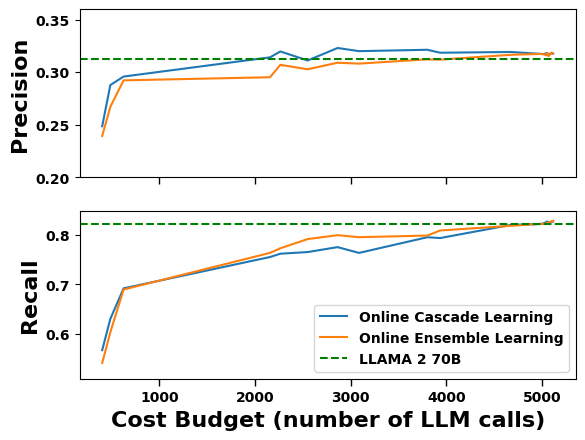

In [22]:
cascade_name = 'LR_BERT-base'
cascade_logs = cascades[cascade_name]
cascade_costs = {
    "GPT": [1, 1182],
    "LLAMA": [1, 636]
}

plot(cascade_logs, cascade_costs)

In [52]:
cascade_name = 'LR_BERT-base_BERT-large'
cascade_logs = cascades[cascade_name]
cascade_costs = {
    "GPT": [1, 3, 1182],
    "LLAMA": [1, 3, 636]
}

plot_both(cascade_logs, cascade_costs)

KeyError: 'LR_BERT-base_BERT-large'